In [37]:
import netCDF4
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
from datetime import datetime, timezone, timedelta
import os
import numpy as np
import pandas as pd
from pyproj import Transformer
import xarray as xr
import time

In [38]:
from datalakes import parse_nc_datalakes_from_folder, datalakes_select_from_depth, datalakes_select_profile, download_data_from_datalakes_dataset
from delft3d_flow import get_closest_index_by_coord
from alplakes import (download_3d_timeserie_from_api, 
                      parse_alplakes_3d_timeserie_from_directory, 
                      parse_alplakes_json_3d_timeserie_to_df, 
                      get_3d_profile_from_api, 
                      parse_json_3d_profile_to_df)
from utils import try_download, open_json, save_json

# Comparison of results between Alplakes and measurements from Datalakes
This notebook displays :
- the timeserie of the temperature at a given location and depth
- the profile of the temperature at a given location and time
- the heatmap of the profile at a given location

It imports the measure from a netcdf file that can be dowloaded on the datalake platform (https://www.datalakes-eawag.ch/data).
If download_and_merge_timeserie_json = True, then it downloads a month of simulation results on Alplakes via the API (https://www.alplakes.eawag.ch/api) and merges it in the existing json file (if it exist). (a month is roughly the max period supported by the API for Lugano lake).
It imports local results from Delft3D flow and Delft3D FM (MapFormat=4) simulations.

In [39]:
lake_name = "geneva"
sta_name = 'geneva_lexplore'

lake_name = "zurich"
sta_name = 'lower_zurich'

In [40]:
depth_plot = 1
end_date = datetime.now()
start_date = end_date - timedelta(days=30) #datetime(2024, 6, 10, 0, 0, 0)

In [41]:
with open(os.path.join('config_points.json'), 'r') as file:
    config_points = json.load(file)[sta_name]
    
lat_station_wgs84 = config_points['lat_station_wgs84']
long_station_wgs84 = config_points['long_station_wgs84']

In [42]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:21781") # WGS84 projection to CH1903 projection
lat_station_ch1903, long_station_ch1903 = transformer.transform(lat_station_wgs84, long_station_wgs84)

# Get data

## Import measure

### From local folder

In [43]:
xr_measure = None
meas_timeserie:xr.DataArray = None
start_clock = time.time()

if 'measure_file_path' in config_points:
    measure_file_path = os.path.join('data/datalakes', config_points['measure_file_path'])
    print(f'Getting data from local file {measure_file_path}')
    xr_measure= xr.open_mfdataset(measure_file_path)
    
elif 'measure_folder_name' in config_points:
    measure_folder_path = os.path.join('data/datalakes', config_points['measure_folder_name'])    
    print(f'Getting data from local folder {measure_folder_path}')
    xr_measure = parse_nc_datalakes_from_folder(measure_folder_path)
    
elif 'datalakes_ds_id' in config_points:
    print(f'Getting data from datalakes dataset {config_points["datalakes_ds_id"]}')
    xr_measure = download_data_from_datalakes_dataset(config_points['datalakes_ds_id'], start_date.replace(tzinfo=timezone.utc), end_date.replace(tzinfo=timezone.utc))
    
if xr_measure is not None:
    meas_timeserie = datalakes_select_from_depth(xr_measure, 'temp', depth_plot)
    
end_clock = time.time()
print(f'Done. Operation took {end_clock - start_clock}s.')

Getting data from datalakes dataset 448
Done. Operation took 1.8692247867584229s.


## Import results Alplakes simulation

### Timeserie

In [44]:
start_download_alplakes = start_date.strftime('%Y%m%d%H%M') #'202305010000'
end_download_alplakes = end_date.strftime('%Y%m%d%H%M') #'202409010000'
alplakes_json_timeserie_directory = rf"data\alplakes_3d\{sta_name}\timeseries_{depth_plot}m"
alplakes_timeserie:pd.DataFrame = None

In [45]:
download_alplakes_from_api:bool = True
save_timeserie_alplakes:bool = False
# -------------------------------------
start_clock = time.time()
if download_alplakes_from_api:    
    alplakes_json = download_3d_timeserie_from_api(lake_name,
                                              start_download_alplakes,
                                              end_download_alplakes,
                                              depth_plot,
                                              lat_station_wgs84,
                                              long_station_wgs84
                                              )
    alplakes_timeserie = parse_alplakes_json_3d_timeserie_to_df(alplakes_json)
    
    if save_timeserie_alplakes:
        alplakes_download_file_path = os.path.join(alplakes_json_timeserie_directory,
                                    f'timeserie_'
                                    f'{lake_name}_'
                                    f'{start_download_alplakes}_'
                                    f'{end_download_alplakes}_'
                                    f'{depth_plot}_'
                                    f'{lat_station_wgs84}_'
                                    f'{long_station_wgs84}.json')
        save_json(alplakes_json, alplakes_download_file_path)

end_clock = time.time()
print(f'Done. Operation took {end_clock - start_clock}s.')

Done. Operation took 14.158108949661255s.


In [46]:
load_alplakes_from_directory:bool = False
# -------------------------------------
if load_alplakes_from_directory:
    alplakes_timeserie = parse_alplakes_3d_timeserie_from_directory(alplakes_json_timeserie_directory)

## Import simstrat alplakes 1d 

alplakes_1d_json_path = os.path.join(r'data\alplakes_1d', config_points['alplakes_1d_name'])
with open(alplakes_1d_json_path) as f:
    simstrat_json_data = json.load(f)

In [47]:
simstrat_data:xr.Dataset = None
if 'alplakes_1d_name' in config_points:
    start_simstrat = start_date.strftime('%Y%m%d%H%M') #'202405120000'
    end_simstrat = end_date.strftime('%Y%m%d%H%M') #'202407010000'
    simstrat_url = rf'https://alplakes-api.eawag.ch/simulations/1d/depthtime/simstrat/{config_points["alplakes_1d_name"]}/T/{start_simstrat}/{end_simstrat}'
    
    simstrat_json_data = try_download(simstrat_url).json()
    datetime_list = [datetime.fromisoformat(date_string).replace(tzinfo=None) for date_string in simstrat_json_data['time']]
    
    # Create xarray dataset
    simstrat_data = xr.Dataset(
        {
            'temperature': (['depth', 'time'], np.stack(simstrat_json_data['T']))
        },
        coords={
            'time': datetime_list,
            'depth': simstrat_json_data['depths']
        }
    )

## Import results local FLOW simulation

In [48]:
def get_flow_results(flow_results_path: str):
    nc_flow = netCDF4.Dataset(flow_results_path)
    flow_coor_index = get_closest_index_by_coord(np.array(nc_flow.variables["XZ"][:]), np.array(nc_flow.variables["YZ"][:]), lat_station_ch1903, long_station_ch1903)
    flow_depth_index = (np.abs(np.array(nc_flow.variables["ZK_LYR"][:]) + depth_plot)).argmin()
    
    flow_times = np.array(nc_flow.variables["time"][:])
    flow_timestamps = [datetime.utcfromtimestamp(t + (datetime(2008, 3, 1).replace(tzinfo=timezone.utc) - datetime(1970, 1, 1).replace(tzinfo=timezone.utc)).total_seconds()).replace(tzinfo=timezone.utc) for t in flow_times]
    flow_depths = np.array(nc_flow.variables["ZK_LYR"])
    
    flow_data = np.array(nc_flow.variables['R1'][:,0,:,flow_coor_index[0],flow_coor_index[1]])
    flow_data[flow_data == -999] = np.nan
    flow_timeserie = pd.DataFrame({
        'time': flow_timestamps,
        'temperature':flow_data[:,flow_depth_index]
                                 })
    
    return flow_timeserie, flow_depths, flow_data

# Plot

## Plot timeseries temperature at depth "depth_simu"

Text(0.5, 1.0, 'Temperature geneva_lexplore at depth 1m')

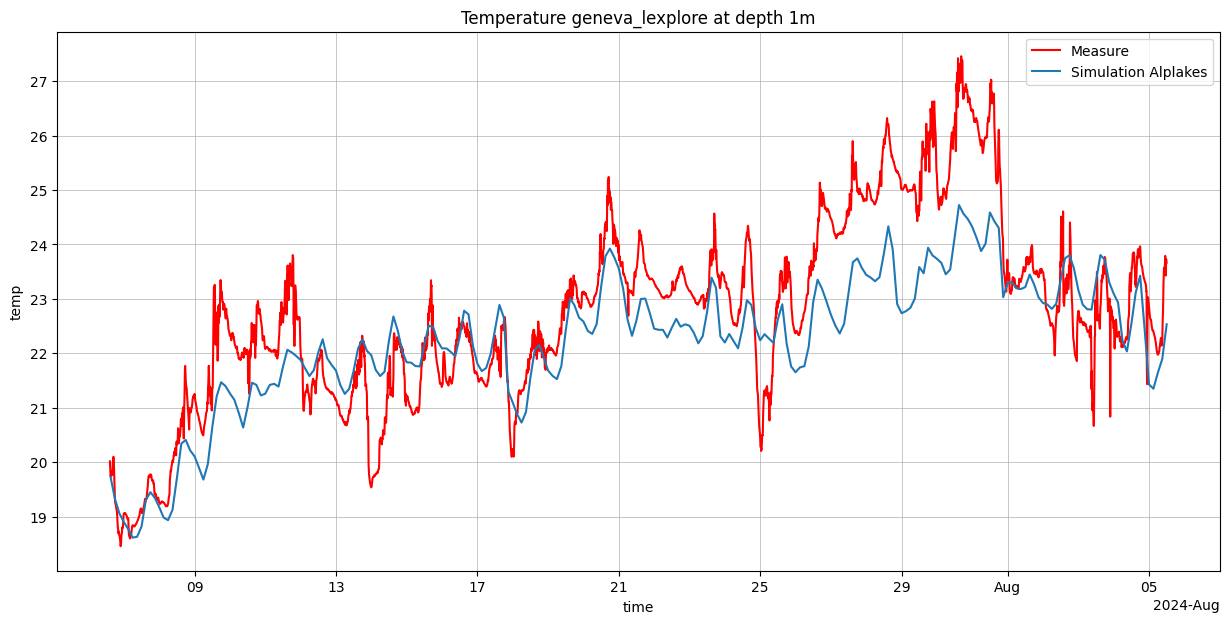

In [49]:
fig, ax = plt.subplots(1,1,figsize=(15, 7))

if meas_timeserie is not None:
    meas_timeserie.sel(time=slice(start_date,end_date)).plot(label=f'Measure', color='r')
if simstrat_data is not None:
    simstrat_data.sel(depth=depth_plot, time=slice(start_date,end_date))['temperature'].plot(label=f'Simulation Simstrat', color='r',linewidth=3)

for item in os.listdir(rf"data\delft3d_flow\{lake_name}\null"):
    flow_results_path = rf"data\delft3d_flow\{lake_name}\2023\{item}\trim-Simulation_Web.nc"
    flow_timeserie, flow_depths, flow_data = get_flow_results(flow_results_path)
    plt.plot(flow_timeserie['time'],flow_timeserie['temperature'], label=f'Simulation {item}')
    
condition_alplakes = (alplakes_timeserie['time']>start_date) & (alplakes_timeserie['time']<end_date)
plt.plot(alplakes_timeserie['time'][condition_alplakes],alplakes_timeserie['temperature'][condition_alplakes], label=f'Simulation Alplakes')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title(f"Temperature {sta_name} at depth {depth_plot}m")

#plt.savefig(rf"output_plots\{lake_name}\timeseries_2023.png")

# Profile

In [50]:
date_plot_profil = datetime.now()
date_plot_profil_str = date_plot_profil.strftime('%Y%m%d%H%M')

In [51]:
# Measures
if xr_measure is not None:
    meas_profile = datalakes_select_profile(xr_measure, 'temp', date_plot_profil)

In [52]:
# Alplakes
alplakes_profile_json_path = rf"data\alplakes_3d\{sta_name}\profiles\profile_{sta_name}_{date_plot_profil_str}m.json"
if not os.path.isfile(alplakes_profile_json_path):
    alplakes_profile_json = get_3d_profile_from_api(lake_name, date_plot_profil_str, lat_station_wgs84, long_station_wgs84)
    save_json(alplakes_profile_json, alplakes_profile_json_path)
else:
    alplakes_profile_json = open_json(alplakes_profile_json_path)
alplakes_profile_data = parse_json_3d_profile_to_df(alplakes_profile_json)

## Plot profils

In [53]:
if simstrat_data is not None:
    simstrat_temp_profile = simstrat_data.sel(time=date_plot_profil, method='nearest')['temperature'].values
    simstrat_depth_profile = -1*simstrat_data.depth.values

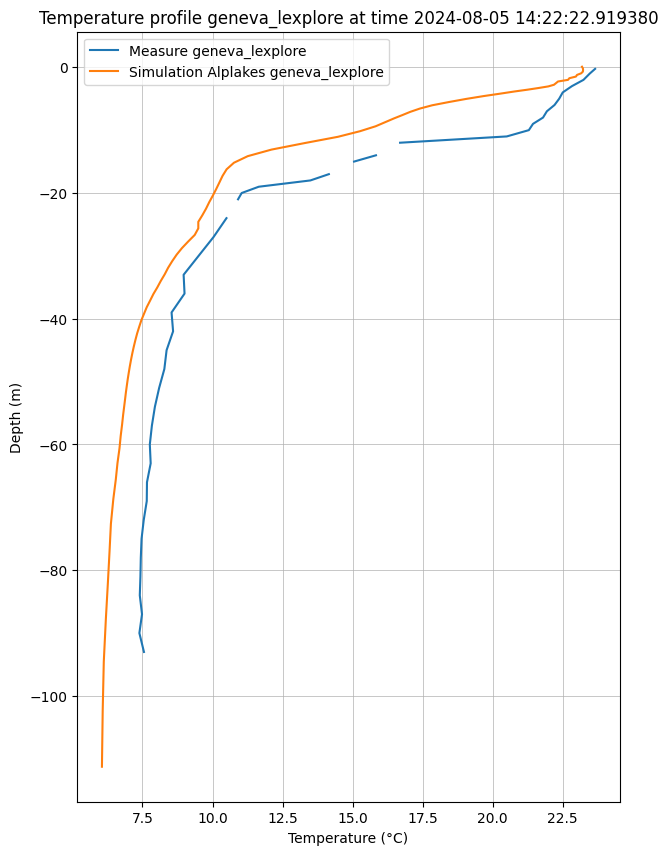

In [54]:
fig = plt.figure(figsize=(7, 10))
if xr_measure is not None:
    plt.plot(meas_profile.values, meas_profile.depth.values, label=f'Measure {sta_name}')
if simstrat_data is not None:
    plt.plot(simstrat_temp_profile, simstrat_depth_profile, label='Simulation Simstrat', color='r')
    
plt.plot(alplakes_profile_data['temperature'],-1*alplakes_profile_data['depth'], label=f'Simulation Alplakes {sta_name}')

plt.title(f"Temperature profile {sta_name} at time {date_plot_profil}")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.ylabel('Depth (m)')
plt.xlabel('Temperature (°C)')
plt.legend()
#plt.savefig(rf"output_plots\{lake_name}\profile_{date_plot_profil.date()}.png")